In [1]:
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Embedding, Activation
from keras.layers import Dropout, SpatialDropout1D
from keras.layers import LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
import pandas as pd
import numpy as np
import nltk
import gensim
import emoji
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/huiyiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
stop_words = stopwords.words('english')

In [3]:
def remove_punct(s):
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', s)
    return no_punct

def remove_emoji(string):
    allchars = [str for str in string]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI['en']]
    clean_text = ' '.join([str for str in string.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [4]:
def tweet_preprocessing(tweet):
    temp = []
    tokens = list(nltk.word_tokenize(tweet.strip()))
    for t in tokens:
        if t in stop_words:
            continue
        token = remove_emoji(t)
        token = remove_punct(token).strip()
        if token:
            temp.append(token)
    return temp

def data_preprocessing(data, test=False):
    texts = []
    labels = []
    for i in tqdm(data.itertuples(), total=len(data)):
        temp = tweet_preprocessing(i.tidyTweet)
        texts.append(temp)
        if not test:
            labels.append(i.Label)
            if i.Label == 1.0:
                texts.extend([temp] * 2)
                labels.extend([i.Label] * 2)
    if not test:
        assert len(texts) == len(labels)
        return texts, labels
    else:
        return texts

In [7]:
train_df = pd.read_csv('./dataset.csv')
train_df = train_df.dropna(subset=['tidyTweet', 'Label'])
texts, labels = data_preprocessing(train_df)

In [14]:
encoder = preprocessing.LabelEncoder()
encoder_y = encoder.fit_transform(labels)
y_cate = to_categorical(encoder_y, num_classes=len(set(encoder_y)))

In [15]:
def build_word2vec_dict(w2v_model):
    vocab_list = list(w2v_model.wv.key_to_index.keys())

    embeddings_matrix = np.zeros((len(vocab_list), w2v_model.vector_size))

    for i in range(len(vocab_list)):
        word = vocab_list[i]
        embeddings_matrix[i] = w2v_model.wv[word]
    return len(vocab_list), embeddings_matrix

def generate_data(texts, w2v_model, maxlen):
    X = []
    words_dict = w2v_model.wv.key_to_index
    for text in texts:
        temp = []
        for word in text:
            if word in words_dict:
                temp.append(words_dict[word])
            else:
                temp.append(1)
        if len(temp) < maxlen:
            temp += [0] * (maxlen - len(temp))
        else:
            temp = temp[:maxlen]
        X.append(temp)
    X = np.array(X)
    return X


In [16]:
maxlen = 128

w2v_model = gensim.models.Word2Vec(
    texts,
    vector_size=300,
    window=5,
    min_count=1,
    workers=5
)

vocab_size, embeddings_matrix = build_word2vec_dict(w2v_model)
X = generate_data(texts, w2v_model, maxlen)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_cate,
    stratify=y_cate,
    test_size=0.2,
    random_state=1
)

In [18]:
model = Sequential()
model.add(
    Embedding(vocab_size,
              300,
              weights=[embeddings_matrix],
              input_length=maxlen,
              trainable=True))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.2)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(y_train.shape[1]))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          9284100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 128, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               60100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2

In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [20]:
filepath = 'lstm_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          verbose=1,
                          mode='max',
                          restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              metrics=['accuracy'])

history = model.fit(X_train,
                    y=y_train,
                    batch_size=128,
                    epochs=16,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/16
110/110 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5451
Epoch 1: val_accuracy improved from -inf to 0.58093, saving model to lstm_weightst.hdf5
110/110 [==============================] - 76s 656ms/step - loss: 0.6877 - accuracy: 0.5451 - val_loss: 0.6745 - val_accuracy: 0.5809
Epoch 2/16
110/110 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6029
Epoch 2: val_accuracy improved from 0.58093 to 0.61490, saving model to lstm_weightst.hdf5
110/110 [==============================] - 71s 643ms/step - loss: 0.6614 - accuracy: 0.6029 - val_loss: 0.6602 - val_accuracy: 0.6149
Epoch 3/16
110/110 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6255
Epoch 3: val_accuracy improved from 0.61490 to 0.63546, saving model to lstm_weightst.hdf5
110/110 [==============================] - 71s 642ms/step - loss: 0.6526 - accuracy: 0.6255 - val_loss: 0.6409 - val_accuracy: 0.6355
Epoch 4/16
110/110 [====================

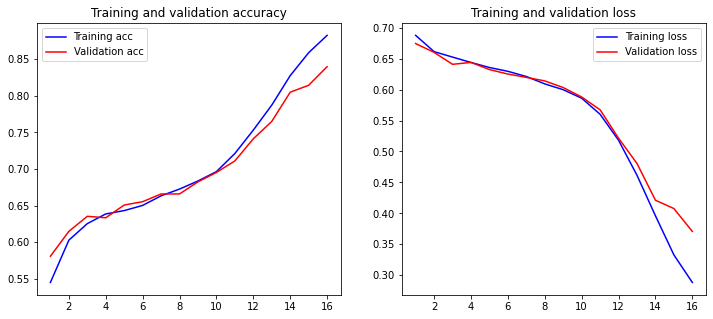

In [21]:
plot_history(history)

In [22]:
history.history

{'loss': [0.687709629535675,
  0.661390483379364,
  0.6525778770446777,
  0.6438831090927124,
  0.635733425617218,
  0.6295689344406128,
  0.621192991733551,
  0.6092382669448853,
  0.599843442440033,
  0.5861261487007141,
  0.5601187944412231,
  0.5181341767311096,
  0.46150121092796326,
  0.39599427580833435,
  0.3328125774860382,
  0.28827905654907227],
 'accuracy': [0.5451106429100037,
  0.6028550863265991,
  0.6254817843437195,
  0.6386866569519043,
  0.643254816532135,
  0.6503211855888367,
  0.6634546518325806,
  0.6726623773574829,
  0.683725893497467,
  0.6965025067329407,
  0.7212705016136169,
  0.7532476782798767,
  0.7873661518096924,
  0.8276231288909912,
  0.8589578866958618,
  0.8826552629470825],
 'val_loss': [0.6744617819786072,
  0.6602225303649902,
  0.6409002542495728,
  0.6439865231513977,
  0.632381021976471,
  0.625171959400177,
  0.6197506189346313,
  0.6140570640563965,
  0.6033292412757874,
  0.5880464911460876,
  0.5673015713691711,
  0.5214409232139587,
  0.

In [24]:
# import json
# with open('lstm_train.txt', 'w') as convert_file:
#      convert_file.write(json.dumps(history.history))

In [25]:
model.load_weights(filepath)
preds = np.argmax(model.predict(X_val), axis=-1)
print(f'acc: {accuracy_score(np.argmax(y_val,axis=-1), preds)}')
print(
    f'precision: {precision_score(np.argmax(y_val,axis=-1), preds,average="macro")}'
)
print(
    f'recall: {recall_score(np.argmax(y_val,axis=-1), preds,average="macro")}')
print(f'f1 score: {f1_score(np.argmax(y_val,axis=-1), preds,average="macro")}')
print(classification_report(np.argmax(y_val, axis=-1), preds, digits=4))

acc: 0.8398515558093063
precision: 0.8402060020860805
recall: 0.8396416706604202
f1 score: 0.8397311877634861
              precision    recall  f1-score   support

           0     0.8319    0.8567    0.8441      1773
           1     0.8485    0.8225    0.8353      1730

    accuracy                         0.8399      3503
   macro avg     0.8402    0.8396    0.8397      3503
weighted avg     0.8401    0.8399    0.8398      3503



In [32]:
filepath = 'lstm_weights.best.hdf5'
model = load_model(filepath)

def test_event(file, model, w2v_model, maxlen):
    test_df = pd.read_csv(file)
    test_df = test_df.dropna(subset=['tidyTweet'])
    test_texts = data_preprocessing(test_df, test=True)
    X_test = generate_data(test_texts, w2v_model, maxlen)
    test_preds = np.argmax(model.predict(X_test), axis=-1)
    test_df['label'] = test_preds
    return test_df

In [33]:
covid_df = test_event('./test_covid_data.csv', model, w2v_model, maxlen)
covid_df.to_csv('lstm_covid_result.csv') 

In [34]:
covid_df.groupby('label').count()

,id,date,search,tweet,tidyTweet
label,,,,,
0,1475,1475,1475,1475,1475
1,479,479,479,479,479


In [35]:
truckers_df = test_event('./test_truckers_data.csv', model, w2v_model, maxlen)
truckers_df.to_csv('lstm_truckers_result.csv') 

In [36]:
truckers_df.groupby('label').count()

,id,date,search,tweet,tidyTweet
label,,,,,
0,1649,1649,1649,1649,1649
1,154,154,154,154,154
